# Affirmation Sample selection

In [1]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from asinh_cmap import asinh_cmap

In [2]:
models = pd.read_pickle('lib/models.pickle')
fm = pd.read_pickle('lib/fitting_metadata.pkl')

In [3]:
chisq_mask = models['tuned_aggregate_chisq'] < 2
bulge_re_mask = models['tuned_aggregate'].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['disk']['Re'] > m['bulge']['Re']
    )
)
comb_mask = chisq_mask ^ bulge_re_mask

## Single Exponential Disk model

In [4]:
def show_contours(model, idx, percentile=95, ax=None):
    if ax is not None:
        plt.sca(ax)
    shape = fm.loc[idx]['galaxy_data'].shape
    psf = fm.loc[idx]['psf']
    for i, c in enumerate(model.keys()):
        if model[c] is None or model[c] == []:
            continue
        m = deepcopy(model)
        m = {k: (
            v
            if k == c or (c =='spiral' and k == 'disk')
            else (None if k != 'spiral' else [])
        )  for k, v in m.items()}
        if not all(v == None or v == [] for v in m.values()):
            if c == 'spiral' and m['disk'] is not None:
                m['disk']['I'] = 0
            r = rendering.calculate_model(m, image_size=shape, psf=psf)
            cs = plt.contour(
                r, levels=[np.percentile(r.ravel(), percentile)], colors=[f'C{i}'],
            )
    
def make_plot(model, idx, **kwargs):
    shape = fm.loc[idx]['galaxy_data'].shape
    render = rendering.calculate_model(
        model, image_size=shape, psf=fm.loc[idx]['psf']
    )
    _, ax = plt.subplots(ncols=3, figsize=(12, 8), dpi=100)
    ax[0].set_title('Reference galaxy')
    ax[0].imshow(fm.loc[idx]['galaxy_data'], cmap=asinh_cmap)
    ax[1].set_title('Fake (Noisy)')
    ax[1].imshow(render + np.random.randn(*shape) * fm.loc[idx]['sigma_image'], cmap=asinh_cmap)
    ax[2].set_title('Fake (Contoured)')
    ax[2].imshow(
        render,
        cmap=asinh_cmap,
    )
    show_contours(model, idx, ax=ax[2], **kwargs)
    for a in ax:
        plt.sca(a)
        plt.axis('off')


Int64Index([21686497, 21686502], dtype='int64')
21686502


parameter,I,Re,c,mux,muy,n,q,roll
component,,,,,,,,
disk,0.107887,30.483476,2.0,89.538084,89.183218,1.0,0.762955,0.700746


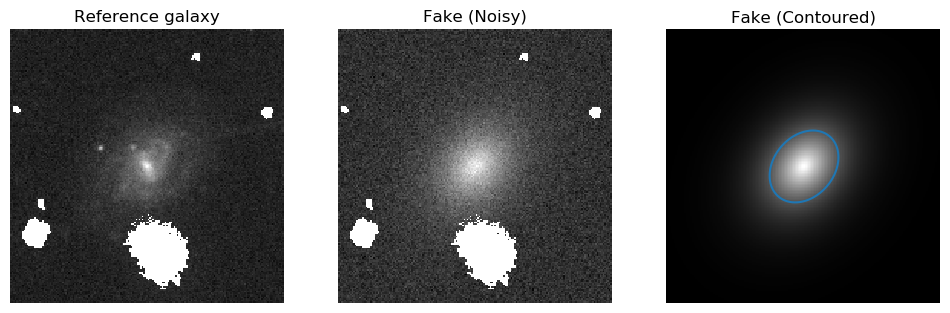

In [5]:
disk_only = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is None
        and m['bar'] is None
        and len(m['spiral']) == 0
    )    
)
print(disk_only[disk_only].index)
disk_idx = 21686502
disk_model = deepcopy(models['tuned_aggregate'].loc[disk_idx])
print(disk_idx)
make_plot(disk_model, disk_idx)
plt.savefig('affirmation_set_models/disk_model.png', bbox_inches='tight')
parsing.to_pandas(disk_model).unstack()

## Exponential Disk + Sersic Bulge model

Int64Index([21096874], dtype='int64')
21096874


parameter,I,Re,c,mux,muy,n,q,roll
component,,,,,,,,
bulge,0.101568,4.494064,2.0,55.583439,55.608295,2.730125,0.601521,0.491234
disk,0.119049,17.228302,2.0,54.903212,57.529685,1.000000,0.571617,0.774281


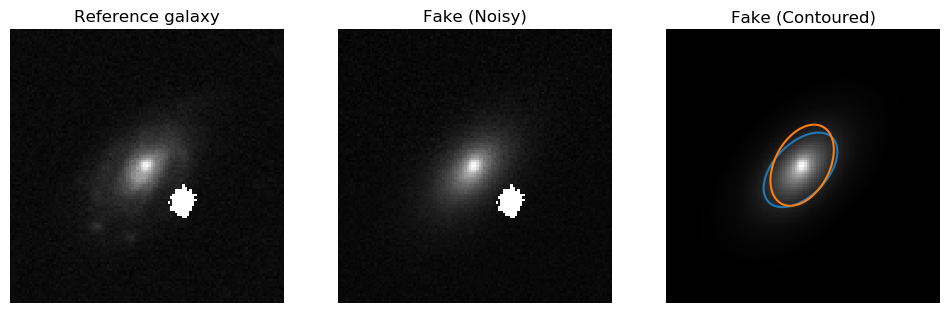

In [6]:
disk_bulge = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bulge']['n'] > 1
        and m['bar'] is None
        and len(m['spiral']) == 0
    )    
)
print(disk_bulge[disk_bulge].index)
disk_bulge_idx = 21096874
disk_bulge_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_idx])
print(disk_bulge_idx)
make_plot(disk_bulge_model, disk_bulge_idx)
plt.savefig('affirmation_set_models/disk_bulge_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_model).unstack()

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar model

Int64Index([20902034, 20902035, 20902063, 20902071, 20902077, 21096902,
            21686563, 21686593],
           dtype='int64')
20902035


parameter,I,Re,c,mux,muy,n,q,roll
component,,,,,,,,
bar,0.219476,4.456223,4.0,44.518629,44.989714,0.200000,0.300000,2.753331
bulge,0.368645,1.144590,2.0,43.536155,43.826034,1.065391,0.785881,2.679479
disk,0.095599,13.916979,2.0,42.909430,44.438921,1.000000,0.735003,3.042427


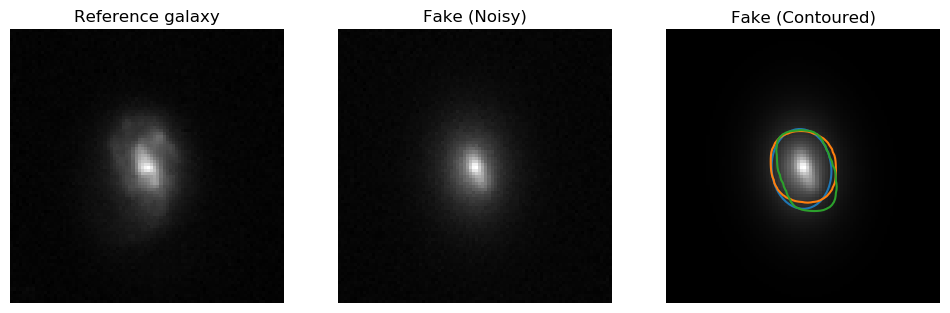

In [7]:
disk_bulge_bar = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bar'] is not None
        and m['bulge']['Re'] > 0
        and m['bulge']['I'] > 0
        and m['bar']['Re'] > 0
#         and m['bar']['I'] > 0
    )    
)
print(disk_bulge_bar[disk_bulge_bar].index)
disk_bulge_bar_idx = 20902035
print(disk_bulge_bar_idx)
disk_bulge_bar_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_idx])
disk_bulge_bar_model['bar']['q'] = 0.3
disk_bulge_bar_model['bar']['c'] = 4
disk_bulge_bar_model['spiral'] = []
make_plot(disk_bulge_bar_model, disk_bulge_bar_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_model).unstack()

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar + 2 Logarithmic spirals model

21686529


parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
bar,0.200000,4.884604,6.0,NaN,125.561053,126.514297,0.800000,0.100000,2.558014,NaN
bulge,0.120000,5.540872,2.0,NaN,126.694915,127.172928,1.881048,0.800000,2.933921,NaN
disk,0.021860,40.569688,2.0,NaN,128.614096,130.168458,1.000000,0.829216,0.577261,NaN
spiral0,0.006546,NaN,NaN,0.336690,NaN,NaN,NaN,NaN,NaN,3.845147
spiral1,0.045667,NaN,NaN,5.945185,NaN,NaN,NaN,NaN,NaN,2.509494
spiral2,0.005852,NaN,NaN,0.607942,NaN,NaN,NaN,NaN,NaN,1.295793


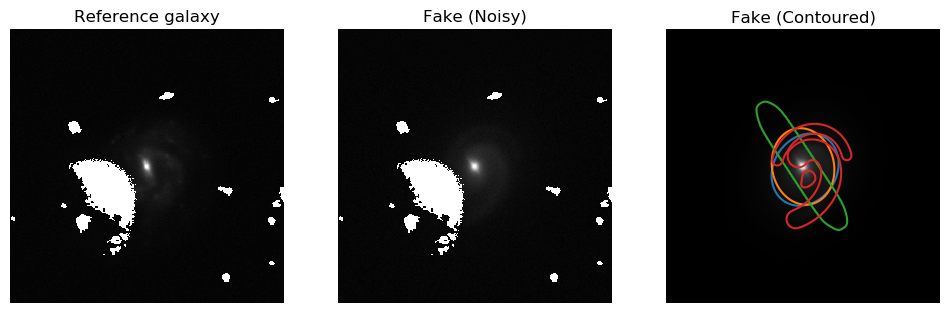

In [16]:
disk_bulge_bar_2spiral_idx = 21686529
disk_bulge_bar_2spiral_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_2spiral_idx])
print(disk_bulge_bar_2spiral_idx)
disk_bulge_bar_2spiral_model['bulge']['I'] = 0.12
disk_bulge_bar_2spiral_model['bulge']['q'] = 0.8
disk_bulge_bar_2spiral_model['bar']['q'] = 0.1
disk_bulge_bar_2spiral_model['bar']['I'] = 0.2
disk_bulge_bar_2spiral_model['bar']['n'] = 0.8
disk_bulge_bar_2spiral_model['bar']['c'] = 6
make_plot(disk_bulge_bar_2spiral_model, disk_bulge_bar_2spiral_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_2spiral_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_2spiral_model).unstack()

Int64Index([20902034, 20902035, 20902063, 20902071, 20902077, 21096902], dtype='int64')
21096902


parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
bar,0.880305,2.289460,2.015944,NaN,70.400000,70.000000,1.698576,0.198281,1.416202,NaN
bulge,0.100000,2.635675,2.000000,NaN,69.769272,68.149178,1.840849,0.800000,1.179687,NaN
disk,0.057918,24.016699,2.000000,NaN,69.155696,72.218379,1.000000,0.788333,2.739691,NaN
spiral0,0.027137,NaN,NaN,0.411521,NaN,NaN,NaN,NaN,NaN,2.051151
spiral1,0.068975,NaN,NaN,0.900102,NaN,NaN,NaN,NaN,NaN,2.276583


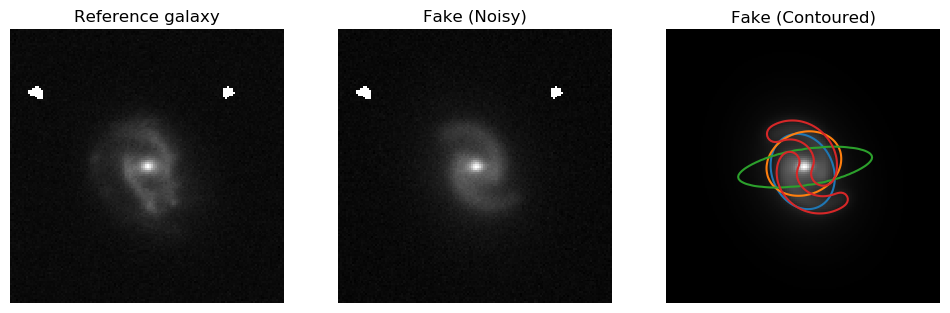

In [9]:
disk_bulge_bar_2spiral = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bar'] is not None
        and m['bulge']['Re'] > 0
        and m['bulge']['I'] > 0
        and m['bar']['Re'] > 0
        and m['bar']['I'] > 0
        and len(m['spiral']) >= 2
    )    
)
print(disk_bulge_bar_2spiral[disk_bulge_bar_2spiral].index)
disk_bulge_bar_2spiral_idx2 = 21096902
disk_bulge_bar_2spiral_model2 = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_2spiral_idx2])
print(disk_bulge_bar_2spiral_idx2)
disk_bulge_bar_2spiral_model2['bulge']['q'] = 0.8
disk_bulge_bar_2spiral_model2['bulge']['I'] = 0.1
make_plot(disk_bulge_bar_2spiral_model2, disk_bulge_bar_2spiral_idx2)
plt.savefig('affirmation_set_models/disk_bulge_bar_2spiral_model2.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_2spiral_model2).unstack()

# Exponential Disk + 2 spirals model

Int64Index([20901990, 20902029, 20902043, 21096838, 21096996], dtype='int64')
21096996


parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
disk,0.018140,29.206548,2.0,NaN,44.819829,45.88567,1.0,0.287925,2.72104,NaN
spiral0,0.070120,NaN,NaN,0.540165,NaN,NaN,NaN,NaN,NaN,1.336680
spiral1,0.340802,NaN,NaN,2.410886,NaN,NaN,NaN,NaN,NaN,12.051407


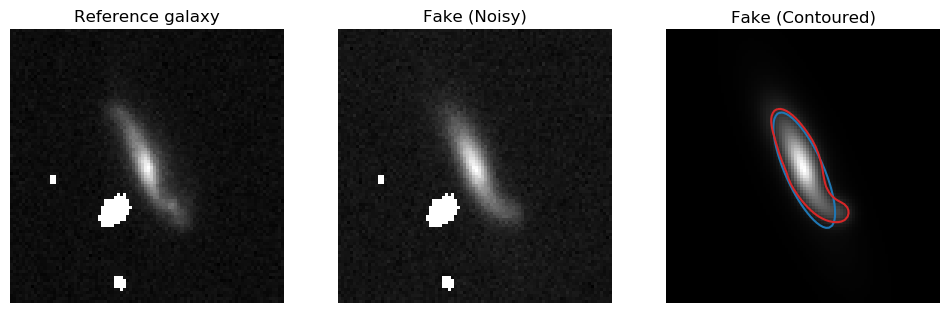

In [10]:
disk_2spiral = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is None
        and m['bar'] is None
        and len(m['spiral']) >= 2
    )    
)
print(disk_2spiral[disk_2spiral].index)
disk_2spiral_idx = 21096996
disk_2spiral_model = deepcopy(models['tuned_aggregate'].loc[disk_2spiral_idx])
print(disk_2spiral_idx)
make_plot(disk_2spiral_model, disk_2spiral_idx)
plt.savefig('affirmation_set_models/disk_2spiral_model.png', bbox_inches='tight')
parsing.to_pandas(disk_2spiral_model).unstack()

20901990


parameter,I,Re,c,falloff,mux,muy,n,q,roll,spread
component,,,,,,,,,,
disk,0.018140,29.206548,2.0,NaN,44.819829,45.88567,1.0,0.287925,2.72104,NaN
spiral0,0.070120,NaN,NaN,0.540165,NaN,NaN,NaN,NaN,NaN,1.336680
spiral1,0.340802,NaN,NaN,2.410886,NaN,NaN,NaN,NaN,NaN,12.051407


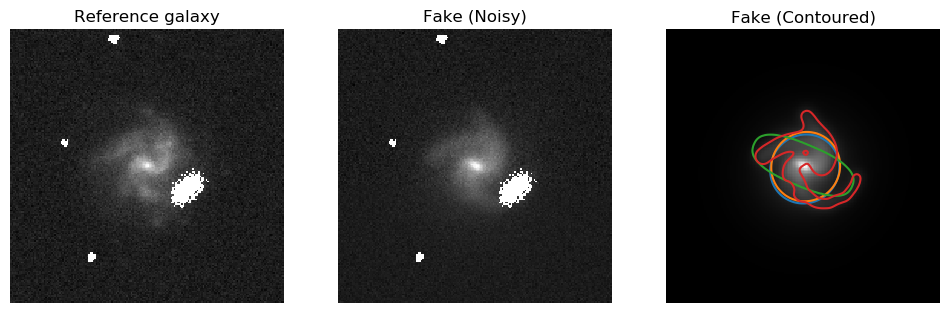

In [11]:
full_idx = 20901990
full_model = deepcopy(models['tuned_best_individual'].loc[full_idx])
full_model['bulge']['Re'] = 5
full_model['bulge']['I'] = 0.1
full_model['bulge']['n'] = 1
print(full_idx)
make_plot(full_model, full_idx, percentile=95)
plt.savefig('affirmation_set_models/full_model.png', bbox_inches='tight')
parsing.to_pandas(disk_2spiral_model).unstack()

In [12]:
import lib.galaxy_utilities as gu

In [13]:
{
    disk_idx: dict(model=disk_model, metadata=gu.metadata.loc[disk_idx].dropna()),
    disk_bulge_idx: dict(model=disk_bulge_model, metadata=gu.metadata.loc[disk_bulge_idx].dropna()),
    disk_bulge_bar_idx: dict(model=disk_bulge_bar_model, metadata=gu.metadata.loc[disk_bulge_bar_idx].dropna()),
    disk_bulge_bar_2spiral_idx: dict(model=disk_bulge_bar_2spiral_model, metadata=gu.metadata.loc[disk_bulge_bar_2spiral_idx].dropna()),
    disk_bulge_bar_2spiral_idx2: dict(model=disk_bulge_bar_2spiral_model2, metadata=gu.metadata.loc[disk_bulge_bar_2spiral_idx2].dropna()),
    full_idx: dict(model=full_model, metadata=gu.metadata.loc[full_idx].dropna()),
}

{21686502: {'model': {'disk': {'I': 0.10788653006172538,
    'Re': 30.483476466485495,
    'c': 2.0,
    'mux': 89.53808385097112,
    'muy': 89.18321842068417,
    'n': 1.0,
    'q': 0.762955111995506,
    'roll': 0.7007455207000531},
   'bulge': None,
   'bar': None,
   'spiral': []},
  'metadata': #models                       [{'frame': 0, 'model': 'GALAXY_BUILDER_DIFFERE...
  #isModelling                                                               True
  ra                                                                   239.464737
  Run                                                                        3225
  dec                                                                   46.306782
  Field                                                                       179
  Rerun                                                                       301
  Camcol                                                                        5
  NSA id                                    